# Generate the perfect trajectory to reduce training time and save time on the track. 

#### Goal :

- Find the optimal number of waypoints
- Find the reward function that allows the algorithm to learn WP customs without overfitting

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import math
import time

from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import shapely.geometry as shp

from scipy.interpolate import interp1d

import seaborn as sns;
sns.set()

from a_star import AStarPlanner
from rear_wheel_feedback import main

from all_waypoints import reinvent_waypoints, kumo_torraku, AWS_track, Shanghai, Toronto, reinvent_waypoints2019, oval, bowtie

%matplotlib inline

## Helpers


In [7]:
def interpolate_waypoints(waypoints):
    points = np.array(waypoints)
    # Linear length along the line:
    distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1)))
    distance = np.insert(distance, 0, 0) / distance[-1]
    # ‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, ‘next’, where ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ 
    alpha = np.linspace(0, 1, 50)
    interpolated_points = {}
    interpolator = interp1d(distance, points, kind='cubic', axis=0)
    interpolated_points = interpolator(alpha)

    return interpolated_points

def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    return ang + 360 if ang < 0 else ang

def get_closest_waypoints_WPCustom(x, y, waypoints):
    current_waypoint = waypoints[0]
    current_dist = dist((x, y), current_waypoint)
    for i, waypoint in enumerate(waypoints):
        if dist((x, y), waypoint) < current_dist:
            current_dist = dist((x, y), waypoint)
            current_waypoint = waypoint
    return current_waypoint


def generateInteriorShape(array, width):
    
    central_waypoints = interpolate_waypoints(array)

    afpoly = shp.Polygon(central_waypoints)
    # Create offset airfoils, both inward and outward
    poffafpoly = afpoly.buffer(width/2)  # Outward offset
    noffafpoly = afpoly.buffer(-width/2)  # Inward offset

    # Turn polygon points into numpy arrays for plotting
    poffafpolypts = np.array(poffafpoly.exterior)
    noffafpolypts = np.array(noffafpoly.exterior)

    poffafpolypts = interpolate_waypoints(poffafpolypts)
    noffafpolypts = interpolate_waypoints(noffafpolypts)
            
    return noffafpolypts

def generateExteriorShape(array, width):
    
    central_waypoints = interpolate_waypoints(array)

    afpoly = shp.Polygon(central_waypoints)
    # Create offset airfoils, both inward and outward
    poffafpoly = afpoly.buffer(width/2)  # Outward offset
    noffafpoly = afpoly.buffer(-width/2)  # Inward offset

    # Turn polygon points into numpy arrays for plotting
    poffafpolypts = np.array(poffafpoly.exterior)
    noffafpolypts = np.array(noffafpoly.exterior)

    poffafpolypts = interpolate_waypoints(poffafpolypts)
    noffafpolypts = interpolate_waypoints(noffafpolypts)
            
    return poffafpolypts


def generateSP(array, SPEED_BOUNDARY, STEP):
    SP = []
    
    for i in range(0, len(array)):
        if i>STEP and i<len(array)-STEP:
            angle = abs(180-getAngle(
            
                array[i-STEP],
                array[i],
                array[i+STEP],
            ))
            
            if angle < SPEED_BOUNDARY:
                SP.append(1)
            else:
                SP.append(0)   
        else:
            SP.append(0)
             
    return SP
        
        
def generateDataForLine(array, up, offset, reward):
    
    SP = generateSP(array, 8, 1)
    WP = []
    
    reward = list(np.ones(len(SP))*reward)
    
    if up == True:
        WP = generateExteriorShape(array, offset)
    else:
        WP = generateInteriorShape(array, offset)
        
    return list(zip([list(point) for point in WP] ,SP, reward ))

## Track Generation

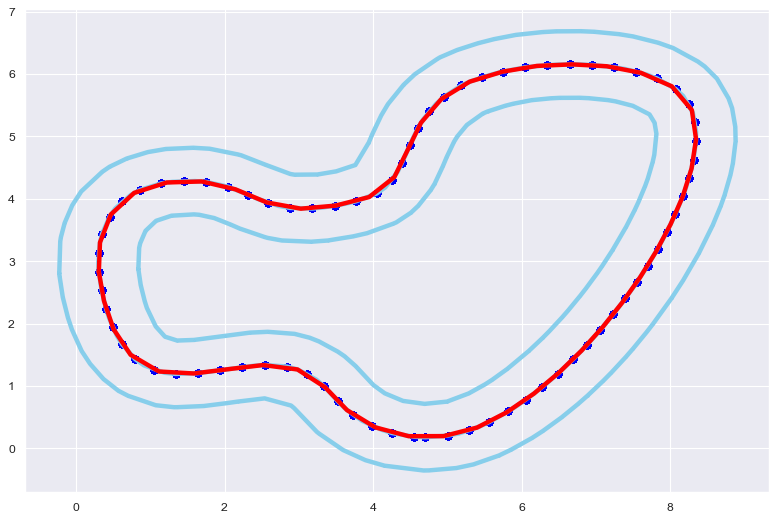

In [8]:
originalWP = reinvent_waypoints2019

class generate_Track():

    def __init__(self):

        self.all_track = [reinvent_waypoints, kumo_torraku, AWS_track, Shanghai, Toronto, reinvent_waypoints2019, bowtie]
        self.all_responses = ['reinvent_waypoints', 'kumo_torraku', 'AWS_track', 'Shanghai', 'Toronto', 'reinvent_waypoints2019',"oval"]
        self.tracks = 'reinvent_waypoints2019'
        self.waypoints = reinvent_waypoints2019
        self.df_waypoints = pd.DataFrame(self.waypoints, columns=['X', 'Y'])
        self.x_origin = self.df_waypoints.X
        self.y_origin = self.df_waypoints.Y


    def interpolate_waypoints(self, waypoints):
        points = np.array(waypoints)
        # Linear length along the line:
        distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1)))
        distance = np.insert(distance, 0, 0) / distance[-1]

        # interpolations_methods = ['cubic','next','previous' ...]
        alpha = np.linspace(0, 1, 100)

        interpolated_points = {}
        interpolator = interp1d(distance, points, kind='next', axis=0)
        interpolated_points = interpolator(alpha)

        
        return interpolated_points

    def generate_both_shapes(self):

        self.central_waypoints = self.interpolate_waypoints(np.array(list(zip(self.x_origin, self.y_origin))))

        afpoly = shp.Polygon(self.central_waypoints)
        # Create offset airfoils, both inward and outward
        poffafpoly = afpoly.buffer(1.0666124816191023/2)  # Outward offset
        noffafpoly = afpoly.buffer(-1.0666124816191023/2)  # Inward offset

        # Turn polygon points into numpy arrays for plotting
        self.poffafpolypts = np.array(poffafpoly.exterior)
        self.noffafpolypts = np.array(noffafpoly.exterior)

        self.poffafpolypts = self.interpolate_waypoints(self.poffafpolypts)
        self.noffafpolypts = self.interpolate_waypoints(self.noffafpolypts)
            
        return self.poffafpolypts, self.noffafpolypts, self.central_waypoints


track = generate_Track()

poffafpolypts, noffafpolypts, central_waypoints = track.generate_both_shapes()

originalWP = [point for i,point in enumerate(originalWP) if i%2==0]

x_WP = [point[0] for i,point in enumerate(originalWP)]
y_WP = [point[1] for i,point in enumerate(originalWP)]

originalWP = interpolate_waypoints(np.array(originalWP))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)            
ax.plot( *poffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *noffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *central_waypoints.T, marker='o', markerfacecolor='blue', markersize=0.1, color='skyblue', linewidth=4)
ax.plot( *originalWP.T, marker='o', markerfacecolor='blue', markersize=0.1, color='red', linewidth=4)
ax.scatter(x_WP*100, y_WP*100, marker='o', alpha=0.3, color='blue')

plt.show()

## Load the waypoints generated

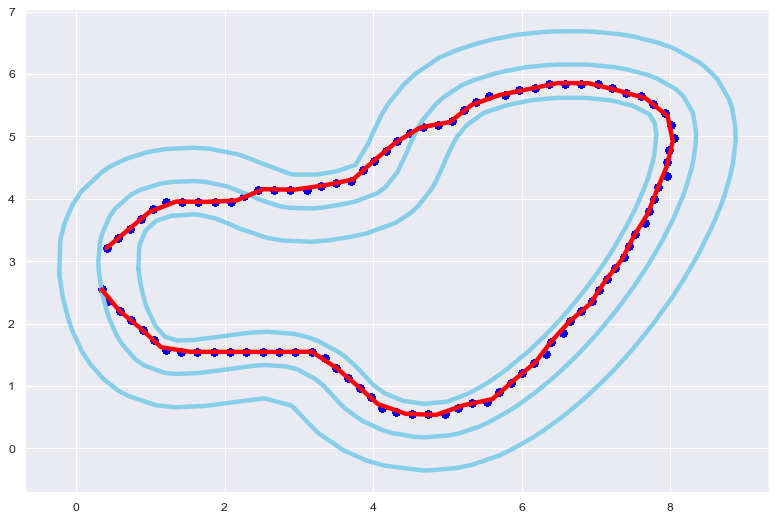

In [9]:
customWP = [(0.34694278119367206, 2.546942781193672),
(0.3505836488019549, 2.4384508530206395),
(0.42911503999605405, 2.3609794995834408),
(0.5114470837290525, 2.2850835113887276),
(0.5866876614361198, 2.206245923980467),
(0.6652794875932642, 2.1288061651635),
(0.7429359861277645, 2.050971047490082),
(0.8206595017753848, 1.9731235568348495),
(0.8985731255482112, 1.8955860108800815),
(0.9760902474862443, 1.8171956878718447),
(1.0541872408963853, 1.7401677028016902),
(1.1325733211862115, 1.6638451055012893),
(1.2054876180299385, 1.5743131716577277),
(1.3024244260622921, 1.5427754235407605),
(1.4145145202257847, 1.5478214363297882),
(1.524083930132849, 1.546781883589184),
(1.6341599897374683, 1.5469655105971631),
(1.7441500855450611, 1.5469415993866422),
(1.8541502905944607, 1.5469420944274457),
(1.9641507249586847, 1.546943143091883),
(2.0741505233558817, 1.5469426563720559),
(2.184150592663669, 1.5469428236983473),
(2.294150558075283, 1.5469427401938978),
(2.4041506301365727, 1.546942914165417),
(2.514150373370686, 1.5469422942776894),
(2.6241512333913177, 1.5469443705511725),
(2.7341488807175276, 1.5469386906941995),
(2.8441522378103863, 1.546946795433307),
(2.9541692592725144, 1.5469878888780224),
(3.0639681383162327, 1.546502339937756),
(3.175272977865945, 1.5496525012749642),
(3.2770508121104567, 1.5298024371984353),
(3.3507869539417223, 1.4422537389803252),
(3.4284299773426476, 1.3641370872263838),
(3.506832122308714, 1.287853117133596),
(3.5843057525474795, 1.2093275138941035),
(3.662167860740245, 1.1317397800350024),
(3.739935804097596, 1.0539247118081612),
(3.8178191465697924, 0.976388238338763),
(3.8951591517157236, 0.8975400494667227),
(3.974035689500026, 0.8224013313506822),
(4.050701971274954, 0.7419266508428604),
(4.124840174438294, 0.6553487259435222),
(4.232607142799678, 0.6499573325961385),
(4.312856063979613, 0.5781343578288498),
(4.4078126033979625, 0.5418086173407489),
(4.520349430743989, 0.547956607762885),
(4.629880671571819, 0.5467538951492881),
(4.739923345953152, 0.547008467021368),
(4.849898902054717, 0.5470379972573685),
(4.960641883510535, 0.5452379256326714),
(5.064593485886743, 0.5598447798880211),
(5.139707219630841, 0.6440662980333245),
(5.248333051430835, 0.6473836395170327),
(5.324687305903431, 0.7286117404987811),
(5.425504070381452, 0.7507818431930999),
(5.538251810538419, 0.7441484886780101),
(5.619968971607415, 0.8124268797448411),
(5.694589129981873, 0.8978518145711449),
(5.7735650497481625, 0.9727247186548056),
(5.851093696618744, 1.0511439073070166),
(5.928909535601946, 1.1289290573109683),
(6.0064519296879535, 1.2067283964669446),
(6.085097471629336, 1.284193754968012),
(6.161292846094868, 1.3626202835984396),
(6.238844164932942, 1.4404990286631278),
(6.329390013220756, 1.5129944519387777),
(6.345151615537974, 1.6164652963090524),
(6.39309772360753, 1.706605492111347),
(6.481447909455401, 1.7800095881537166),
(6.560251834177416, 1.8573679495812048),
(6.6422402265786875, 1.933407244163662),
(6.645971772350411, 2.041861586568453),
(6.715292975280985, 2.123147804354384),
(6.79858683101793, 2.1986463594454695),
(6.88259183027326, 2.2738503495282516),
(6.9486247645571435, 2.3564986125655047),
(6.95259641743654, 2.4648535000801752),
(7.035991651386626, 2.5403100631401063),
(7.131124079563698, 2.610904921167299),
(7.143038818092517, 2.7159696748767694),
(7.202978913328286, 2.801141674500121),
(7.249679200985755, 2.891797781985696),
(7.271769637753737, 2.992647623477642),
(7.369932696905552, 3.061987153052945),
(7.44479846975252, 3.140976734582186),
(7.446488982642519, 3.2502765012157875),
(7.4515320191691305, 3.3581876070906733),
(7.530340110392027, 3.4355442268806984),
(7.622519467962595, 3.507362286811069),
(7.652521779975853, 3.604934922252591),
(7.639366554429449, 3.720383995152831),
(7.708292161076926, 3.801834073729832),
(7.747129767273281, 3.895747011515764),
(7.783470177814767, 3.9906943163314925),
(7.854604520737864, 4.071229516436658),
(7.840032607494354, 4.187265365383036),
(7.877986233993628, 4.281544642485702),
(7.951518565500354, 4.36108621287879),
(7.94510265534851, 4.473745035695428),
(7.948680710166885, 4.582256310297952),
(7.940997429357983, 4.695469860278562),
(7.984226148150421, 4.787402799091332),
(8.053120631828941, 4.869219011551117),
(8.043881926625213, 4.981755024391001),
(8.053425721368765, 5.093841218592969),
(8.009051641392995, 5.1860618907733365),
(7.94351730156591, 5.2686533774054105),
(7.934778596248439, 5.375342609845726),
(7.845420170350083, 5.448046348432838),
(7.765674344974027, 5.523387691389779),
(7.694581421496615, 5.61305712463013),
(7.600581465738994, 5.653422147562408),
(7.484652270835577, 5.638769254753351),
(7.399317397917677, 5.698413067137633),
(7.310056882234987, 5.748445945319585),
(7.210879427085555, 5.7745816421259875),
(7.132900570824553, 5.851885171380097),
(7.0201349520982355, 5.8452079250385545),
(6.911062012965777, 5.847450173395126),
(6.800802230188923, 5.846803227719381),
(6.690852209120742, 5.8470075304705755),
(6.580903075831042, 5.846809363659096),
(6.470679216153465, 5.84736554662766),
(6.361320211887653, 5.845815202367556),
(6.250261894336493, 5.848370602144925),
(6.173747152891517, 5.76752993279038),
(6.0734790185852905, 5.744035219850533),
(5.962548548389947, 5.746281558352752),
(5.851528381457021, 5.748744461443435),
(5.774299591053579, 5.669627762187334),
(5.67591010607933, 5.641597499815042),
(5.561360025517223, 5.652582365935055),
(5.483407696136252, 5.5752124449065175),
(5.385092664587786, 5.547002435582913),
(5.291618920337342, 5.5071045248200825),
(5.218907657306687, 5.417081550303644),
(5.141046960467497, 5.339490408727896),
(5.066370944146735, 5.254210768252433),
(4.958327389027245, 5.249487492487852),
(4.878626404327417, 5.176339198823635),
(4.783555719465053, 5.140296643741403),
(4.667866724798307, 5.154031091822128),
(4.588086822560703, 5.081073321947915),
(4.492605860125902, 5.046021264545411),
(4.396052369496022, 5.013558519257492),
(4.324638828892395, 4.92040256565881),
(4.245587278488069, 4.845686398910512),
(4.167674638047728, 4.768220660280845),
(4.090159779169495, 4.689794592009076),
(4.012187677959547, 4.612472404375824),
(3.934563225995713, 4.534310917217647),
(3.856854401996729, 4.456353122171022),
(3.777818498968235, 4.38159917931578),
(3.7048546574859267, 4.29218598312417),
(3.6154928369590595, 4.242361010337445),
(3.5036719700700774, 4.246756971876096),
(3.3910901880669515, 4.252989945003135),
(3.301608108134744, 4.203455304103787),
(3.2177119422224263, 4.14043507381937),
(3.104283648770232, 4.148711706367456),
(2.9952000128314165, 4.146499407822866),
(2.8849611487126348, 4.147076076817994),
(2.7750774331164667, 4.146795341433172),
(2.664856340580972, 4.147329106030904),
(2.5553384126923047, 4.146165281001686),
(2.445358740255974, 4.146116205921778),
(2.370530406902841, 4.06120429129165),
(2.2653538399784616, 4.04955949374329),
(2.1833581084288722, 3.9819512090459743),
(2.0902192307750753, 3.941244858800941),
(1.9773723812944723, 3.9481177614270426),
(1.867945273311399, 3.9467346777500043),
(1.7578474762815648, 3.9469707806657914),
(1.6478594462959926, 3.94694188249462),
(1.537866011387804, 3.946926032960931),
(1.4278040163414227, 3.947075702242699),
(1.3181815502699772, 3.9461642547121287),
(1.2062586801090938, 3.9508064739332176),
(1.108133852277437, 3.922137272228889),
(1.0350992230722955, 3.8328949727177952),
(0.956865533346436, 3.7562043156274103),
(0.8787000590821261, 3.6793489718445955),
(0.80118537917261, 3.6009224715041217),
(0.7233079667135227, 3.5233716850043373),
(0.6455453408295855, 3.445543779198046),
(0.5677654664609093, 3.3677575149175363),
(0.4899800790716644, 3.289984560246059),
(0.4122001287800581, 3.2121984792597233),
(0.34694278119367206, 2.546942781193672)]


customWP = [point for i,point in enumerate(customWP) if i%2==0]

x_WP = [point[0] for i,point in enumerate(customWP)]
y_WP = [point[1] for i,point in enumerate(customWP)]

customWP = interpolate_waypoints(np.array(customWP))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)            
ax.plot( *poffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *noffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *central_waypoints.T, marker='o', markerfacecolor='blue', markersize=0.1, color='skyblue', linewidth=4)
ax.plot( *customWP.T, marker='o', markerfacecolor='blue', markersize=0.1, color='red', linewidth=4)
ax.scatter(x_WP*100, y_WP*100, marker='o', alpha=0.3, color='blue')

plt.show()

## Improve the quality of the waypoints

#### 1st Methode : interpolation

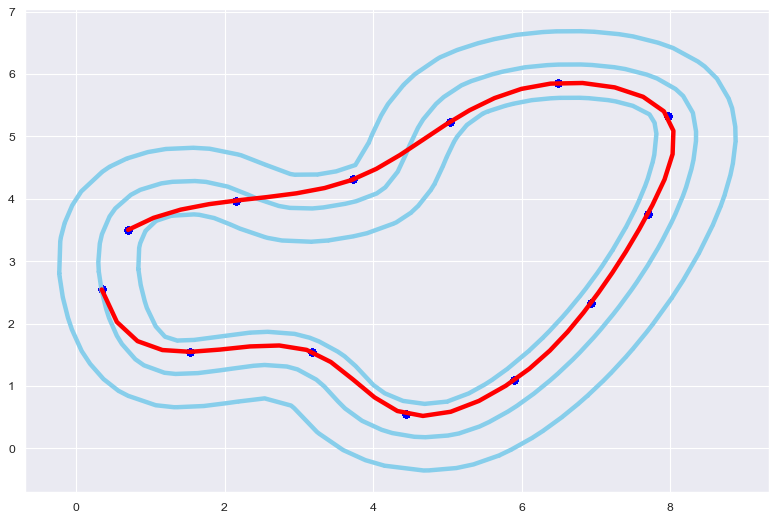

In [10]:
customWP = [point for i,point in enumerate(customWP) if i%2==0]
customWP = [point for i,point in enumerate(customWP) if i%2==0]

x_WP = [point[0] for i,point in enumerate(customWP)]
y_WP = [point[1] for i,point in enumerate(customWP)]

customWP_interpolated = interpolate_waypoints(np.array(customWP))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)            
ax.plot( *poffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *noffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *central_waypoints.T, marker='o', markerfacecolor='blue', markersize=0.1, color='skyblue', linewidth=4)
ax.plot( *customWP_interpolated.T, marker='o', markerfacecolor='blue', markersize=0.1, color='red', linewidth=4)
ax.scatter(x_WP*100, y_WP*100, marker='o', alpha=0.3, color='blue')

plt.show()

#### 2st Methode : Manually changing the remaining waypoints

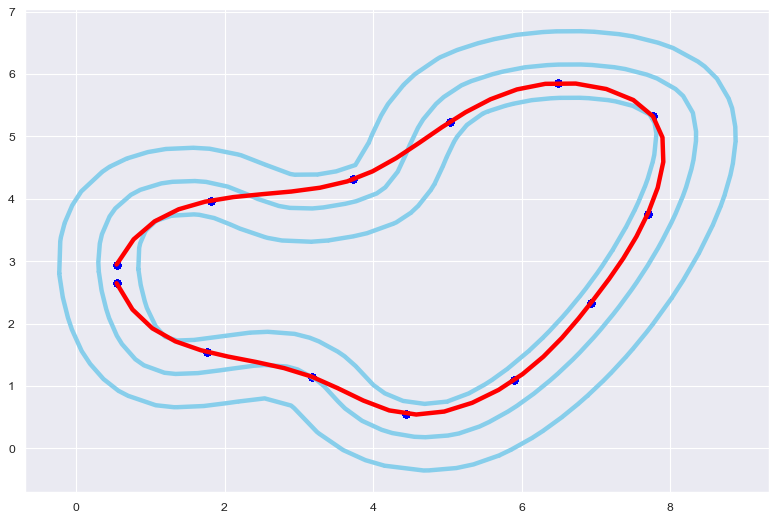

In [11]:
customWPRectified = [
    
 [0.54694278119367206, 2.646942781193672],
 [1.762077918334898, 1.5479452343984192],
 [3.1748417763272374, 1.1497609540426285],
 [4.437929250603391, 0.5548874438264204],
 [5.891651480418385, 1.0893195106974998],
 [6.927071418230558, 2.325531558323984],
 [7.697189021368252, 3.7612662301365023],
 [7.763395218656995, 5.325337174589367],
 [6.485829411155439, 5.854660254568551],
 [5.032074351779525, 5.2303152347933075],
 [3.730003512173267, 4.30921355614083],
 [1.81595793553355698, 3.972345091988817],
 [0.54694278119367206, 2.946942781193672]]

x_WP = [point[0] for i,point in enumerate(customWPRectified)]
y_WP = [point[1] for i,point in enumerate(customWPRectified)]

customWPRectifiedInterpolated = interpolate_waypoints(np.array(customWPRectified))

fig, ax = plt.subplots(figsize=(12, 8), dpi=80)            
ax.plot( *poffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *noffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *central_waypoints.T, marker='o', markerfacecolor='blue', markersize=0.1, color='skyblue', linewidth=4)
ax.plot( *customWPRectifiedInterpolated.T, marker='o', markerfacecolor='blue', markersize=0.1, color='red', linewidth=4)
ax.scatter(x_WP*100, y_WP*100, marker='o', alpha=0.3, color='blue')

plt.show()

## Fit all points in track with its corresponding path

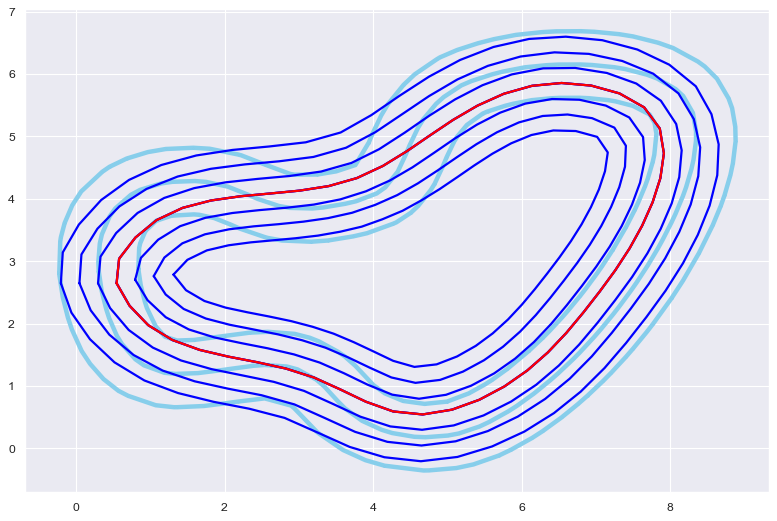

In [12]:
OFFSET = 0.5
NUMBER_OF_PATH = 4

all_path = [generateDataForLine(customWPRectifiedInterpolated, True, 0, 15)]


for i in range(0,NUMBER_OF_PATH):
    all_path.append(generateDataForLine(customWPRectifiedInterpolated, True, OFFSET*i, 10-i))
    all_path.append(generateDataForLine(customWPRectifiedInterpolated, False, OFFSET*i, 10-i))

    
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)            
ax.plot( *poffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *noffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *central_waypoints.T, marker='o', markerfacecolor='blue', markersize=0.1, color='skyblue', linewidth=4)
for i, path in enumerate(all_path):
    if i == 2:
        ax.plot( *np.array([point[0] for point in path]).T, marker='o', markerfacecolor='red', markersize=0.01, color='red', linewidth=2)
    else:
        ax.plot( *np.array([point[0] for point in path]).T, marker='o', markerfacecolor='blue', markersize=0.01, color='blue', linewidth=2)
    


plt.show()

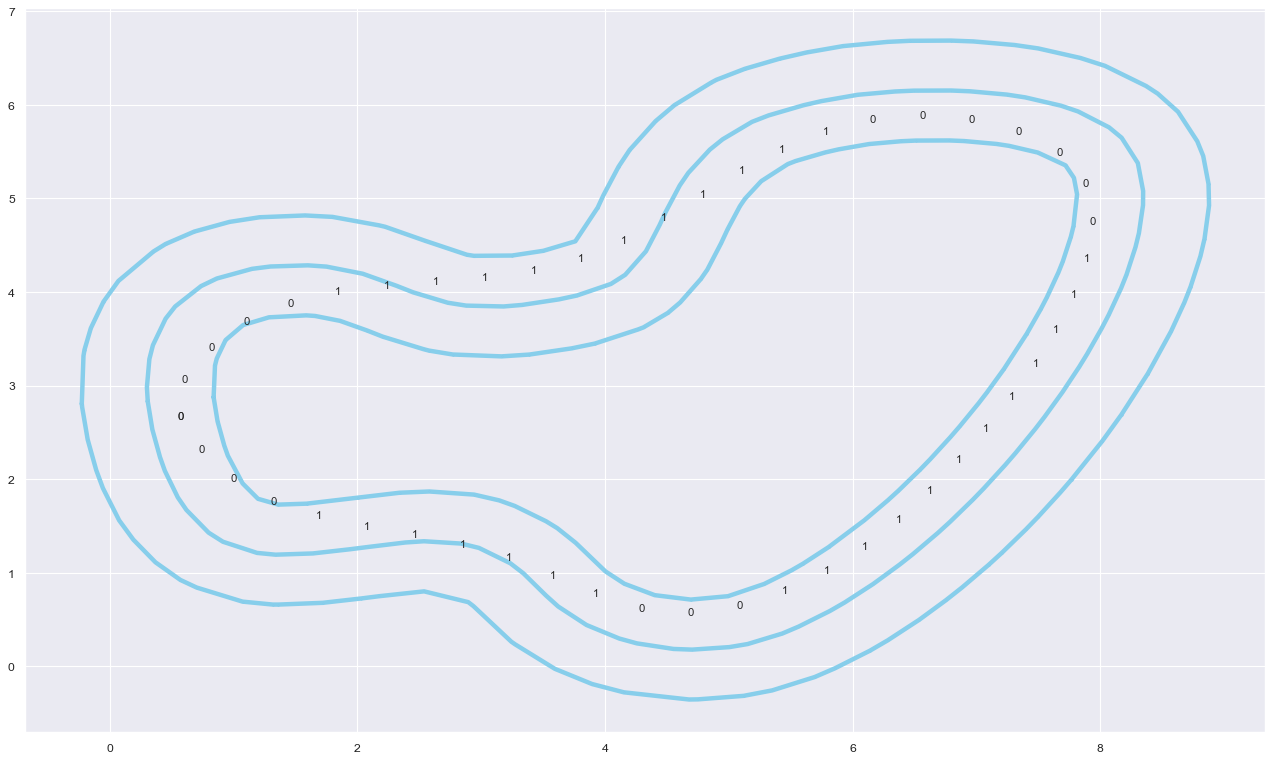

In [13]:
SP = generateSP([point[0] for point in all_path[2]], 11, 1)

fig, ax = plt.subplots(figsize=(20, 12), dpi=80)            
ax.plot( *poffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *noffafpolypts.T, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
ax.plot( *central_waypoints.T, marker='o', markerfacecolor='blue', markersize=0.1, color='skyblue', linewidth=4)

for i, txt in enumerate(SP):
    ax.annotate(round(txt), ([point[0] for point in all_path[0]][i][0], [point[0] for point in all_path[0]][i][1]))

plt.show()